In [4]:
import re
import sys
import pandas as pd
import numpy as np
import gensim 
from tqdm import tqdm

papers = pd.read_csv("nips_paper/papers.csv")
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [13]:
print(papers.columns)
print(papers.shape)

Index(['id', 'year', 'title', 'event_type', 'pdf_name', 'abstract',
       'paper_text'],
      dtype='object')
(7241, 7)


In [14]:
import spacy 
from nltk.corpus import stopwords
nlp = spacy.load('en_core_web_sm')

def clean_paper_text(text):
    
    cleaned_text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)
    cleaned_text = re.sub(r"[~:]"," ",cleaned_text)    
    parsed_text = cleaned_text.split("\n")
    cleaned_text = [sen.strip() for sen in parsed_text if len(sen.split()) > 3]
    return "\n".join(cleaned_text)

In [51]:
papers['cleaned_paper_text'] = papers ['paper_text'].apply(lambda x:clean_paper_text(x))

In [52]:
headers = ["id", "cleaned_paper_text"]
papers.to_csv('nips_paper/papers_cleaned.csv', columns = headers, index=False)

In [15]:
papers_phrase = pd.read_csv("nips_paper/papers_phrased.csv")

In [16]:
papers_phrase.shape

(7241, 2)

In [17]:
print(papers_phrase.shape)
print(papers_phrase.columns)
papers_phrase.head()

(7241, 2)
Index(['<phrase>id</phrase>', 'cleaned_paper_text'], dtype='object')


,<phrase>id</phrase>,cleaned_paper_text
0,1,<phrase>SELF-ORGANIZATION</phrase> OF <phrase>...
1,10,A <phrase>MEAN FIELD</phrase> THEORY OF LAYER ...
2,100,STORING <phrase>COVARIANCE</phrase> BY THE <ph...
3,1000,<phrase>Bayesian</phrase> <phrase>Query Constr...
4,1001,"<phrase>Neural Network Ensembles</phrase>, Cro..."


In [18]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

def reformat_phrase(text):
    if type(text) != str:
        text = str(text)
    text = text.replace("<phrase>", "<phrase> ").replace("</phrase>", " </phrase> ")
    
    reformatted_text = []
    for sent in text.split("\n"):
        #print(sent)
        stack = []
        reformatted_sent = []
        for c in sent.split()[:200]:
            if "<phrase>" in c:
                stack.append(c)
            elif len(stack) >0:
                stack.append(c)
                if stack[-1] == "</phrase>":
                    phrase = []
                    while stack:
                        phrase.append(stack.pop().lower())
                    reformatted_sent.append("_".join((phrase)[-2:0:-1]))
                else:
                    continue
            else:
                reformatted_sent.append(c.lower())
        reformatted_text.append(" ".join(reformatted_sent))
    
    ## original sentences are seperated. 
    ## Re-tokenize the text into sentences and split the words with puncts.
    tokenize_sents = [" ".join(s.split()) for s in sent_tokenize(" ".join(reformatted_text)) if len(s.split()) >2 ]
    
    return tokenize_sents

In [19]:
papers_phrase['phrased_paper_text'] = papers_phrase['cleaned_paper_text'].apply(lambda x:reformat_phrase(x))

In [20]:
def merge_sent(x):
    return "\n".join(x)

## merge the sentence list into one text and output one csv file
papers_phrase['saved_phrase_paper_text'] = papers_phrase['phrased_paper_text'].apply(lambda x:merge_sent(x))
headers = ["id", "saved_phrase_paper_text"]
papers_phrase.columns = ['id', 'cleaned_paper_text', 'phrased_paper_text', 'saved_phrase_paper_text']

print(len(papers_phrase['id']))
print(len(papers_phrase['saved_phrase_paper_text']))
saved_phrased = papers_phrase[headers].copy()

saved_phrased.to_csv('nips_paper/papers_cleaned_phrased.csv', index=False)

7241
7241


In [21]:
all_sentences = []
for i in range(len(papers_phrase['phrased_paper_text'])):
    all_sentences += papers_phrase['phrased_paper_text'][i]
               
print(len(all_sentences))

2218923


In [176]:
import time
class MySentences(object):
    def __init__(self, sentences):
         self.sents = sentences
    def __iter__(self):
        for line in self.sents:
            yield line.split()

st = time.time()
sentences = MySentences(all_sentences) 
model = gensim.models.Word2Vec(sentences, size=50, min_count=2, workers=20, iter=5)
model.save("nips_paper/nips_phrase.model")
print('Finished in {:.2f}'.format(time.time()-st))

Finished in 280.34


In [9]:
phrase_model = gensim.models.Word2Vec.load("nips_paper/nips_phrase.model")

In [10]:
phrase_model.wv.most_similar('machine_learning', topn=10)

[('data_analysis', 0.7317827343940735),
 ('information_retrieval', 0.7208462953567505),
 ('econometrics', 0.7110494375228882),
 ('natural_language_processing', 0.7043561935424805),
 ('distributed_learning', 0.7025482654571533),
 ('combinatorial_optimization', 0.699896514415741),
 ('computer_vision', 0.6995106339454651),
 ('modern', 0.6951709985733032),
 ('numerical_linear_algebra', 0.6933628916740417),
 ('statistical_learning', 0.6916418075561523)]

In [11]:
phrase_model.wv.most_similar('computer_science', topn=10)

[('electrical_engineering', 0.8786921501159668),
 ('department', 0.862352192401886),
 ('computing_science', 0.8608720898628235),
 ('university', 0.8440576791763306),
 ('georgia_institute_of_technology', 0.8338526487350464),
 ('california', 0.8235242366790771),
 ('school', 0.8209803104400635),
 ('massachusetts_institute_of_technology', 0.8135727047920227),
 ('information_science', 0.8040677905082703),
 ('institute', 0.7948373556137085)]

In [12]:
word_model = gensim.models.Word2Vec.load("nips_paper/nips_word.model")

In [22]:
print(len(all_sentences))

phrase_freq = dict()
p2id = dict()
id2p = list()
    
word_freq = dict()
w2id = dict()
id2w = list()

for sent in all_sentences:
    for word in sent.strip().split():
        if "_" not in word:
            if word not in w2id:
                w2id[word] = len(id2w)
                id2w.append(word)
                
            if word not in word_freq:
                word_freq[word] =1    
            else:
                word_freq[word] +=1
        else:
            if word not in p2id:
                p2id[word] = len(id2p)
                id2p.append(word)
                
            if word not in phrase_freq: 
                phrase_freq[word] =1
            else:
                phrase_freq[word] +=1
    

2218923


In [23]:
len(word_freq), len(phrase_freq), len(id2w), len(id2p) 

(478710, 51695, 478710, 51695)

In [31]:
sorted_phrases = sorted(phrase_freq.items(), key=lambda item: item[1], reverse=True)

In [212]:
phrase_model.wv.most_similar('active_learning', topn=10)

[('online_learning', 0.8734085559844971),
 ('supervised_learning', 0.8335028886795044),
 ('transfer_learning', 0.8110494613647461),
 ('pac_learning', 0.7809466123580933),
 ('transductive', 0.7773299217224121),
 ('selective_sampling', 0.7620036602020264),
 ('domain_adaptation', 0.7555958032608032),
 ('semi-supervised_learning', 0.7489196062088013),
 ('model_selection', 0.7448408603668213),
 ('online', 0.7340937256813049)]

In [53]:
phrase = [p[0] for p in sorted_phrases[:500]]
phrase

['et_al',
 '=_0',
 'machine_learning',
 'figure_1',
 'neural_networks',
 'training_set',
 'neural_network',
 'training_data',
 'reinforcement_learning',
 'advances_in_neural_information_processing_systems',
 'objective_function',
 'computer_vision',
 'loss_function',
 'computer_science',
 'mit_press',
 'international_conference',
 'optimization_problem',
 'section_3',
 'artificial_intelligence',
 'gradient_descent',
 'section_4',
 'neural_information_processing_systems',
 'covariance_matrix',
 'random_variables',
 'supplementary_material',
 'new_york',
 'technical_report',
 'log_n',
 'gaussian_process',
 'active_learning',
 'pattern_recognition',
 'special_case',
 'an_efficient',
 'generative_model',
 'posterior_distribution',
 'mutual_information',
 'latent_variables',
 'random_variable',
 'convex_optimization',
 'probability_distribution',
 'cost_function',
 'time_series',
 'maximum_likelihood',
 'ground_truth',
 'feature_space',
 'logistic_regression',
 'section_5',
 'standard_devia

In [46]:
X=phrase_model[phrase]
df=pd.DataFrame(X)
df.shape
df.head()

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-2.536171,0.236651,8.320289,1.378310,2.087486,-1.376370,-2.180070,-1.568391,-1.665407,2.023477,...,7.999616,2.260242,0.510665,-3.993670,6.299641,-0.643555,1.926361,0.695584,4.835688,5.371355
1,5.061749,-0.640049,-0.338942,-2.055281,1.687355,3.068201,1.919786,-0.104997,0.105266,4.251467,...,-6.543857,-0.962769,-2.019865,0.031970,0.044570,0.291499,-2.100451,2.946857,-0.769304,3.302348
2,-1.321342,2.062315,-1.089281,-0.179222,-1.942009,2.662498,3.304721,0.455313,-2.766257,-0.028777,...,-0.227898,3.120526,1.604438,4.555813,2.630162,-1.784012,2.722403,0.009299,-2.288456,-4.272758
3,-1.734614,3.612258,-0.066497,4.955315,-5.487803,0.535682,-3.505342,-2.130696,-1.146488,-0.207635,...,0.445149,1.114153,3.057949,-1.738192,-1.552913,4.126401,-1.830413,-1.678176,-1.828046,2.077866
4,-4.390011,-0.569048,-0.874150,-0.947715,0.567891,-0.283323,0.873008,2.765760,-0.827040,-2.563819,...,1.050453,3.153764,3.117557,1.025085,0.585570,-1.435347,1.518599,-0.880564,0.677854,-2.374675


In [47]:
X_corr=df.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(X_corr)

#Sorting the eigen vectors coresponding to eigen values in descending order
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]

#Projecting it onto new dimesion with 2 axis
neww_X=np.dot(X,new_vectors)

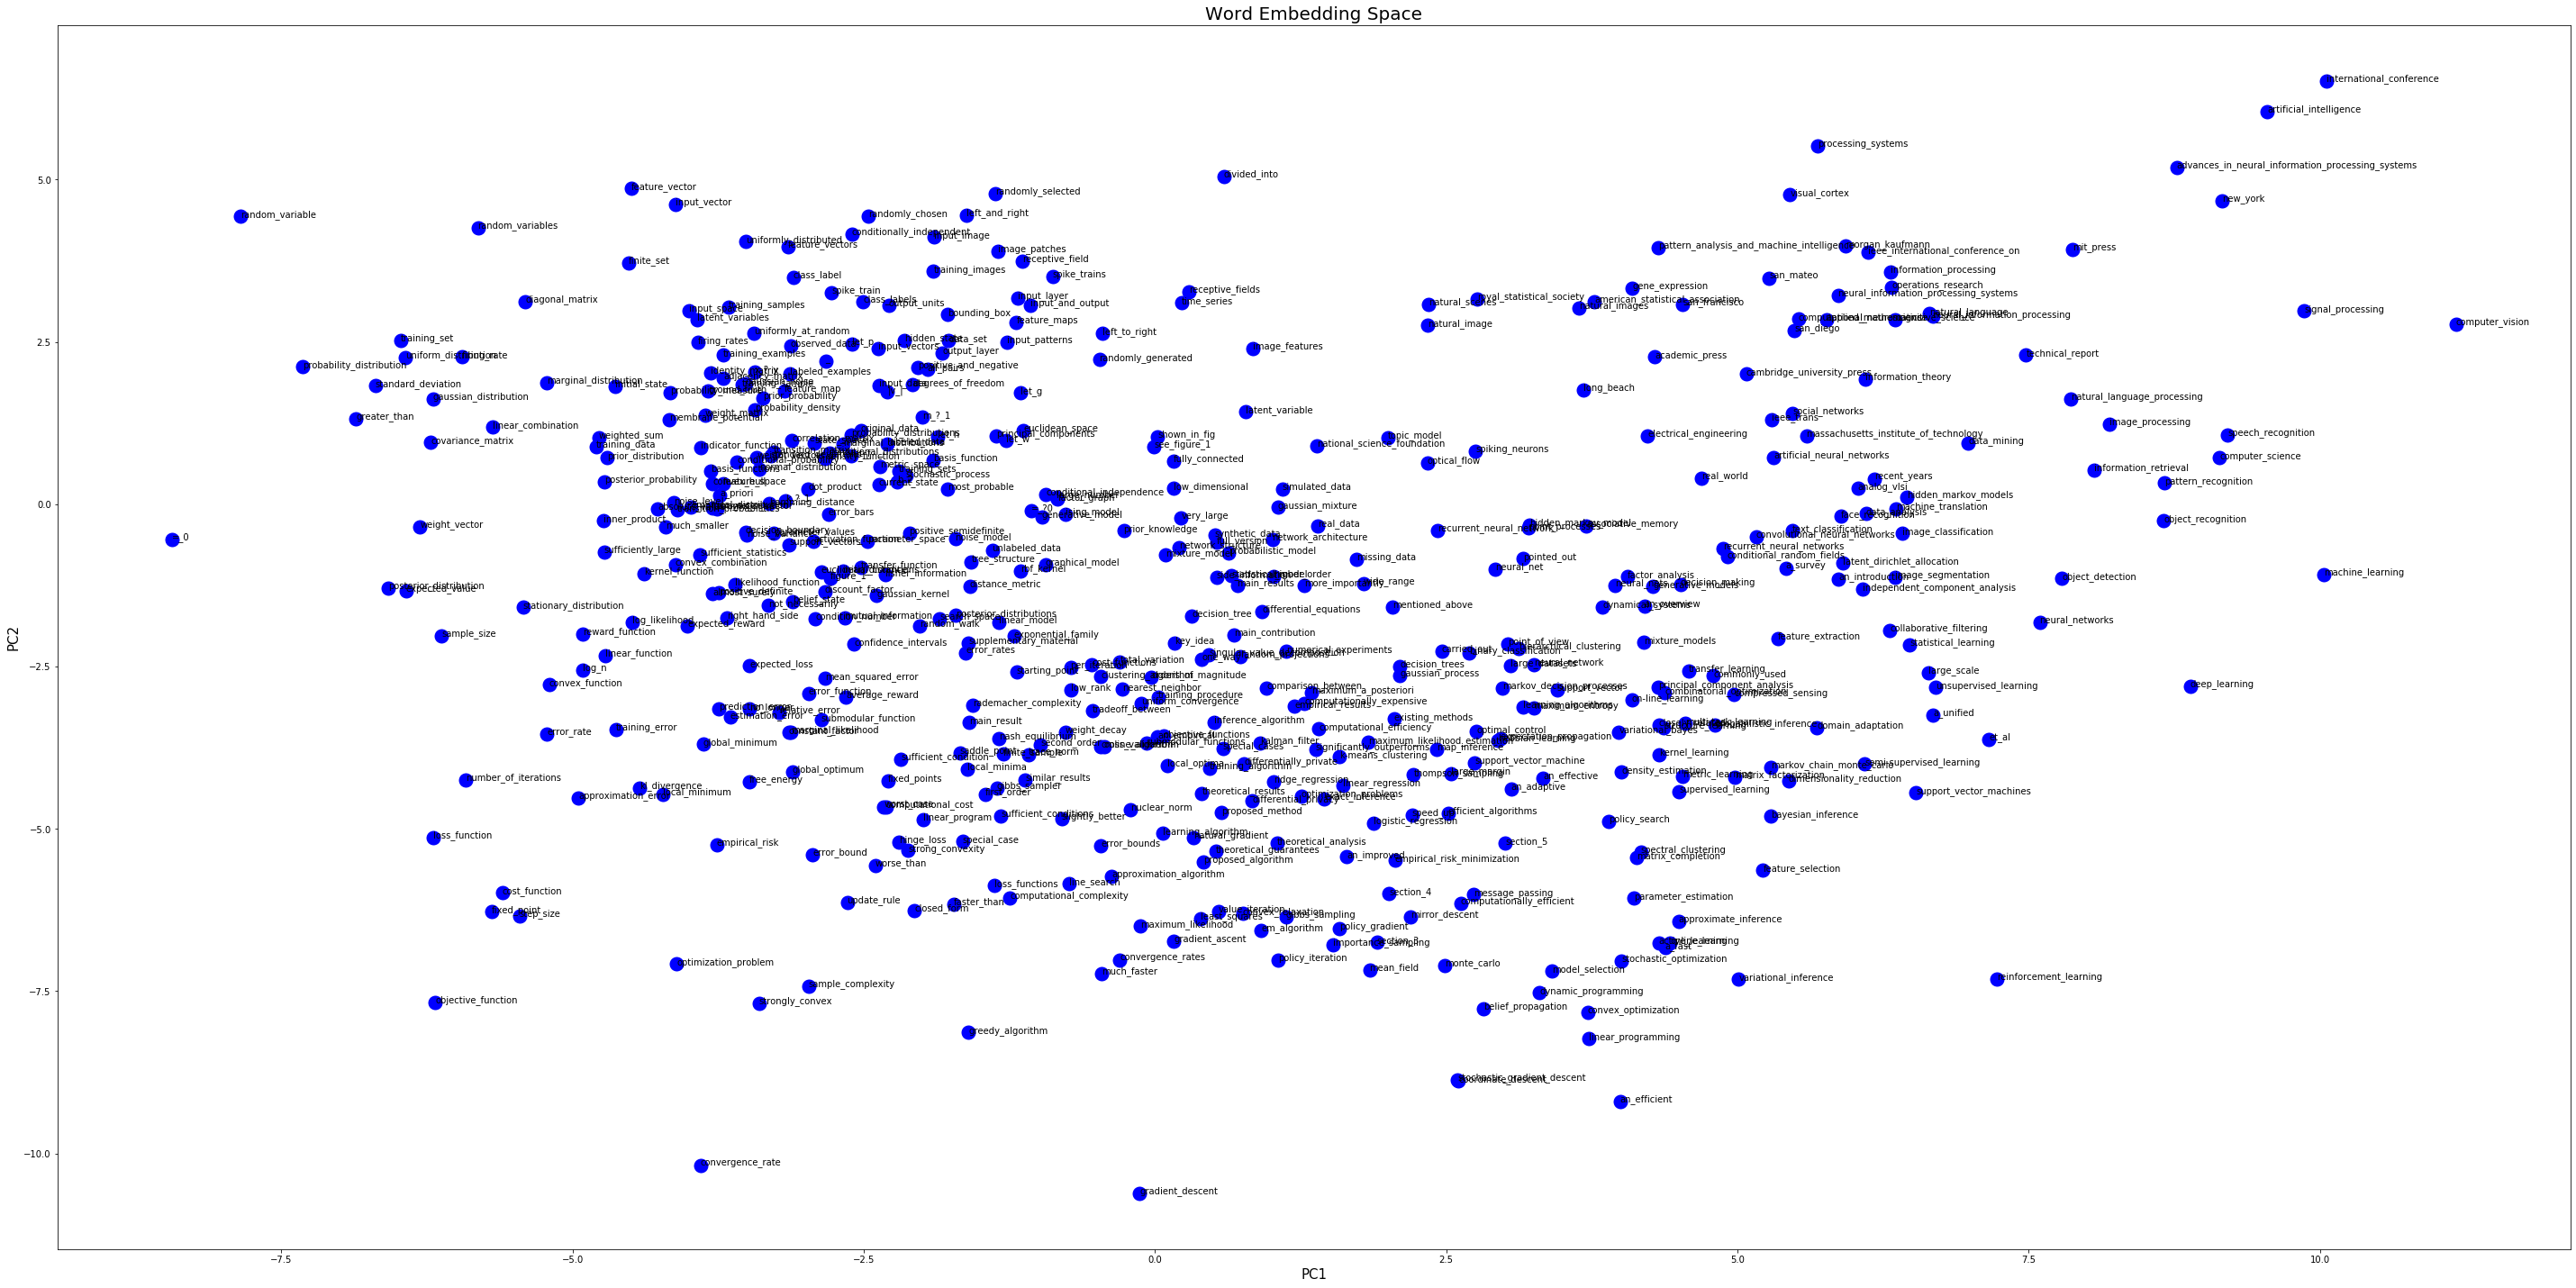

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,25))
plt.scatter(neww_X[:,0],neww_X[:,1],linewidths=10,color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
vocab=list(phrase)
for i, word in enumerate(vocab):
    plt.annotate(word,xy=(neww_X[i,0],neww_X[i,1]))

词向量总数：---------- 4047
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4047 samples in 0.007s...


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


[t-SNE] Computed neighbors for 4047 samples in 1.741s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4047
[t-SNE] Computed conditional probabilities for sample 2000 / 4047
[t-SNE] Computed conditional probabilities for sample 3000 / 4047
[t-SNE] Computed conditional probabilities for sample 4000 / 4047
[t-SNE] Computed conditional probabilities for sample 4047 / 4047
[t-SNE] Mean sigma: 0.930178
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.199348
[t-SNE] KL divergence after 2500 iterations: 1.972990


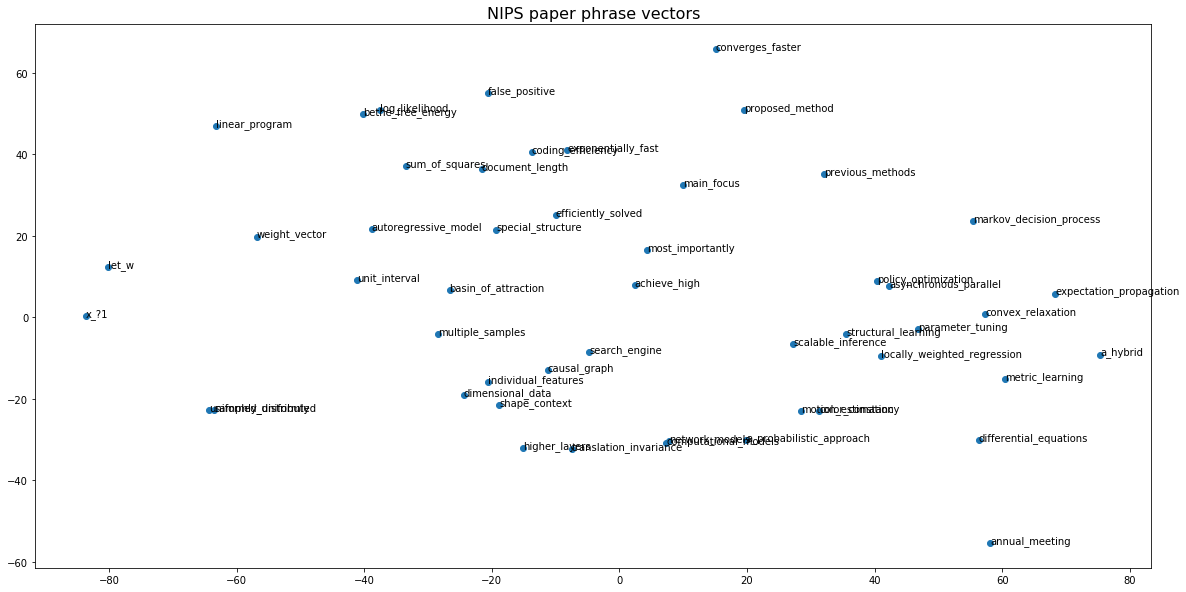

In [75]:
import random
phrase = [p for p in phrase_model.wv.vocab if "_" in p and phrase_freq[p] > 50]
random.shuffle(phrase)

vector = phrase_model[phrase]
random_word2vec = TSNE(n_components=2, init='pca', verbose=1, n_iter=2500, random_state=23).fit_transform(vector)

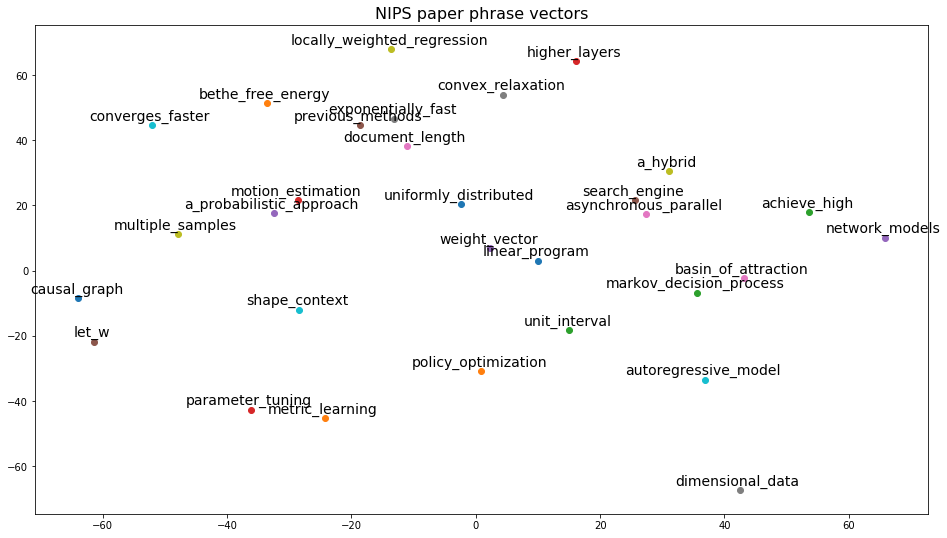

In [350]:
plt.figure(figsize=(16, 9))

'''
similar = []
selected = phrase.index("active_learning")
similar.append(selected)
similar += [phrase.index(e[0]) for e in phrase_model.wv.most_similar('active_learning', topn=30) if "_" in e[0]]

selected2 = phrase.index("computer_vision")
similar.append(selected2)
similar += [phrase.index(e[0]) for e in phrase_model.wv.most_similar('support_vector_machine', topn=30) if "_" in e[0]]
'''
selected = random.sample(range(len(phrase)),30)
random.shuffle(selected)

for i in range(len(selected)):
    x = random_word2vec[selected[i]][0]
    y = random_word2vec[selected[i]][1]
    plt.scatter(x,y)
    plt.annotate(phrase[i],
                 xy=(x,y), 
                 xytext=(-2, 2),
                 textcoords='offset points',
                 size = 14,
                 ha='center',
                 va='bottom',
                 in_layout=True)

#plt.title('NIPS paper phrase vectors', size=16)
#plt.savefig("phrase.jpg", dpi=200)
#plt.show()


In [351]:
authors = pd.read_csv("nips_paper/authors.csv")
paper_authors = pd.read_csv("nips_paper/paper_authors.csv")
print(authors.shape[0])
print(paper_authors.shape[0])

9784
20838


In [352]:
authors.head()

,id,name
0,1,Hisashi Suzuki
1,10,David Brady
2,100,Santosh S. Venkatesh
3,1000,Charles Fefferman
4,10000,Artur Speiser


In [353]:
paper_authors.head()

,id,paper_id,author_id
0,1,63,94
1,2,80,124
2,3,80,125
3,4,80,126
4,5,80,127


In [357]:
authors_new = authors.rename(columns = {'id':'author_id'})
paper_authors_merged = pd.merge(paper_authors, authors_new, on='author_id', how='left')

In [498]:
papers_new = saved_phrased.rename(columns = {'id':'paper_id'})
paper_author_text_merged = pd.merge(paper_authors, papers_new, on='paper_id', how='left')

In [499]:
def topN_phrases(text):
    
    merge_all_papers = " ".join(text.replace("\n", " "))
    topN_dict = dict()
    for w in merge_all_papers.strip().split(): 
        if "_" in w:
            if w not in topN_dict:
                topN_dict[w] =0
            else:
                topN_dict[w] +=1
    topN_list = [i[0] for i in sorted(topN_dict.items(), key=lambda item:item[1])[:20]]
    
    if len(topN_list)==0:
        print(text)
    #print(topN_list)
    return topN_list
    
    

In [503]:
paper_author_text_merged.head()
author_paper_filterd = paper_author_text_merged[["author_id","paper_id", "saved_phrase_paper_text"]].groupby("author_id").filter(lambda x: len(x) > 1)
author_paper_filtered_group = author_paper_filterd[["author_id","paper_id", "saved_phrase_paper_text"]].groupby("author_id")
print(author_paper_filterd.shape)

(14394, 3)


In [504]:
author_topN = author_paper_filtered_group["saved_phrase_paper_text"].apply(lambda x:topN_phrases(x)).reset_index(name="topN_phrases")

In [505]:
def average_phrase_vectors(topN, phrase_vectors):
    
    if len(topN):
        avg = np.mean([phrase_vectors.wv[each] for each in topN if each in phrase_vectors.wv], axis=0)
        return avg
    else:
        return None
author_topN["avg_vec"] = author_topN["topN_phrases"].apply(lambda x: average_phrase_vectors(x, phrase_model))

In [508]:
author_topN.shape

(3340, 3)

In [509]:
author_topN_merged = pd.merge(author_topN, authors_new, on='author_id', how='left')

In [510]:
author_topN_merged

,author_id,topN_phrases,avg_vec,name
0,4,"[optimization_models, neural_model, computatio...","[-0.5384939, -0.23768622, -0.51408714, -0.1736...",John C. Platt
1,5,"[optimization_models, neural_model, computatio...","[-0.46629182, 0.08013349, -0.43157768, 0.24689...",Alan H. Barr
2,6,"[ibm_thomas_j, signal_correlations, developmen...","[-0.6210832, 0.045104872, -0.093748145, 0.0780...",Ralph Linsker
3,11,"[cross_coupling, large_extent, easily_modifiab...","[-0.39247328, 0.019200703, -0.04953709, -0.140...",Demetri Psaltis
4,12,"[nonlinear_regression, excitatory_and_inhibito...","[-0.47351354, 0.0012147052, 0.2348212, 0.03120...",Frank H. Eeckman
...,...,...,...,...
3335,10311,"[general_equilibrium, based_learning, great_su...","[-0.20937571, -0.49345842, -0.28904593, -0.438...",Nicholas Bambos
3336,10346,"[columbia_university, duke_university, stanfor...","[-0.43146276, 0.30124846, 0.10568416, -0.15092...",Eleanor Batty
3337,10376,"[strongly_related, modeling_language, reason_a...","[-0.036047786, -0.31548262, -0.27613378, -0.44...",Venkatadheeraj Pichapati
3338,10453,"[related_groups, statistical_information, empi...","[-0.12360547, -0.07403028, -0.37006465, 0.0373...",Susan Athey


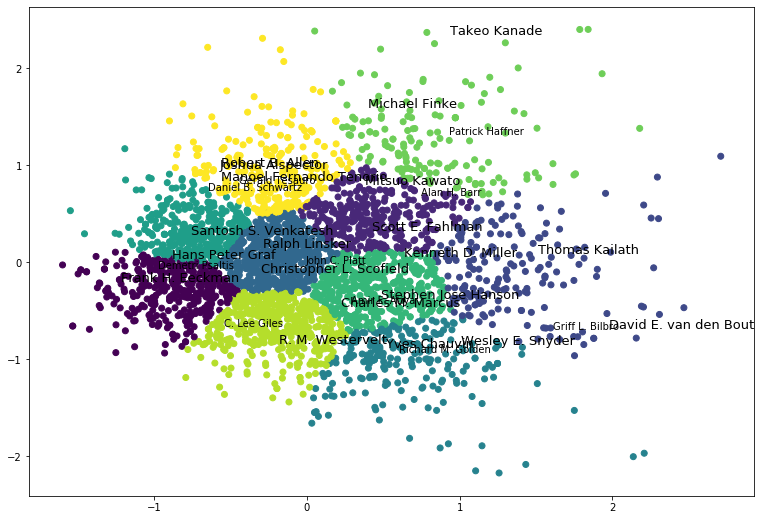

In [533]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


km = KMeans(n_clusters=10)
pca = PCA(n_components=2)

author_name = []
vectors = []
for i in range(len(author_topN_merged["author_id"])):
    vectors.append(author_topN_merged["avg_vec"][i])
    author_name.append(author_topN_merged['name'][i])

    
# dimension deduction
vectors_ = pca.fit_transform(vectors)

plt.figure(figsize=(13, 9))
# k-means clustering
y_ = km.fit_predict(vectors_)
plt.scatter(vectors_[:,0],vectors_[:, 1],c=y_)

#y_[5:10]
class_ann = dict()
for i in range(len(author_name)):
    if y_[i] not in class_ann:
        class_ann[y_[i]] = 1
        plt.annotate(s=author_name[i], xy=(vectors_[:, 0][i], vectors_[:, 1][i]),
                 xytext=(vectors_[:, 0][i] + 0.1, vectors_[:, 1][i] + 0.1))
    else:
        if class_ann[y_[i]] > 2:
            continue
        else:
            plt.annotate(s=author_name[i], xy=(vectors_[:, 0][i], vectors_[:, 1][i]),
                 xytext=(vectors_[:, 0][i] + 0.1, vectors_[:, 1][i] + 0.1), size=13)
            class_ann[y_[i]] +=1        
plt.show()
    